In [1]:
# imports and config
import numpy as np
import matplotlib.pyplot as plt
import _lib.pr_func as pr
from _lib.environment import * 
from _lib.agents import *
from plot_trajectories import *
from IPython.display import Image
from pathlib import Path
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format='retina'

In [2]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

# S2 Notebook: Grid world simulations

This notebook is published as supporting information accompanying the article _Gottwald, Braun. The two kinds of free energy and the Bayesian revolution_. This is a rendered version of the [jupyter notebook available on github](https://github.com/sgttwld/two-kinds-of-free-energy--notebooks) using animated gif images instead of real simulations.

# 1. _Simulations_

Below we have implemented various inference-based agents discussed in the article in a simple grid world environment.  The grid world consists of a square with two inner wall blocks and two targets. One of the targets is covered in a region of bad visibility (almost uniform $p_0(X|S)$), visualized with a gray background. The transition probability is assumed to be perfect (i.e. $p_0(S'|S,A)$ is a Dirac distribution given by the grid). Note that the grid world setup can be changed freely in the jupyter notebook on github. 

In order to be able to compare the pure inference-based and utility-based approaches with Active Inference, we have assumed a desired distribution for all methods. However, as discussed in the article, the approaches differ in how they treat such a distribution, e.g. $p_\mathrm{des}(X)$ might be viewed as a success probability $p(R=1|X)$ (when conditioning on success), or $\log p_\mathrm{des}(X)$ as a utility $U(X)$. In the simulations below where a soft-maximization appears, we have set the optional precision parameter $\alpha=1$. One can easily test other values in the available juypter notebook, but for this simple environment higher values seem to make little to no difference (lower values result in more random behavior, of course).  

In [3]:
# define environment (jupyter notebook only)
plan1 = """
1 1 1 1 1 1
1 0 0 0 G 1
1 S 1 0 0 1
1 0 0 0 0 1
1 0 1 0 G 1
1 1 1 1 1 1
"""
plan2 = """
1 1 1 1 1 1
1 0 0 0 G 1
1 S 0 0 0 1
1 0 0 0 0 1
1 0 0 0 G 1
1 1 1 1 1 1
"""
# the likelihood for each state is a gaussian with sigmas given by the following matrix:
c = 100.0
sigmas = np.array([
    [.1,.1,.1,.1,.1,.1],
    [.1,.1,.1, c, c,.1],
    [.1,.1,.1, c, c,.1],
    [.1,.1,.1,.1,.1,.1],
    [.1,.1,.1,.1,.1,.1],
    [.1,.1,.1,.1,.1,.1]])
# agent steps (needs to be low to make active inference algorithms feasable)
steps = 5

## Overview: _Approaches using exact inference_ 
For the following overview of the resulting behavior of the different agents, we have performed 1000 trials. We display the eight most probable paths for each agent (or all in case there are less than 8 different ones), where we use differently dotted lines for each path, with the density of dots indicating the rank in the probability rating.

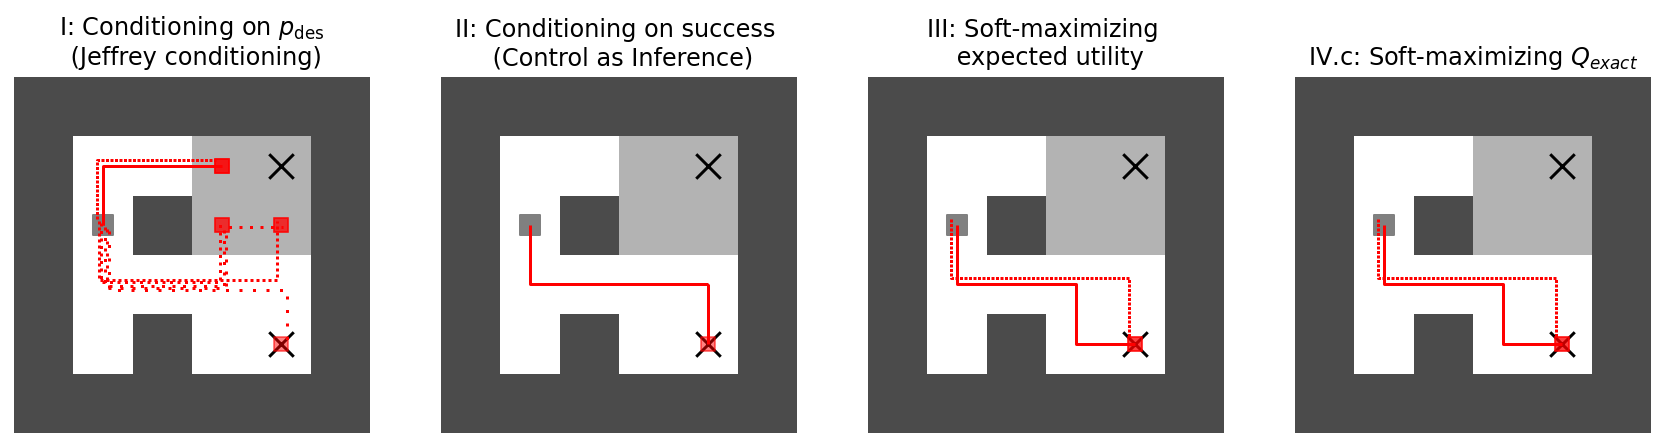

In [4]:
# load trajectories from file and show most probable ones
env = GridEnv(plan=plan1,render=False)
select = ['jeff','touss','util','qexact']
trajectories = load_trajectories(select,walls=True)
show_paths(env,sigmas,steps,trajectories,select,spec=[1,4],num=8)

## Overview: _Approaches using variational/approximate inference_

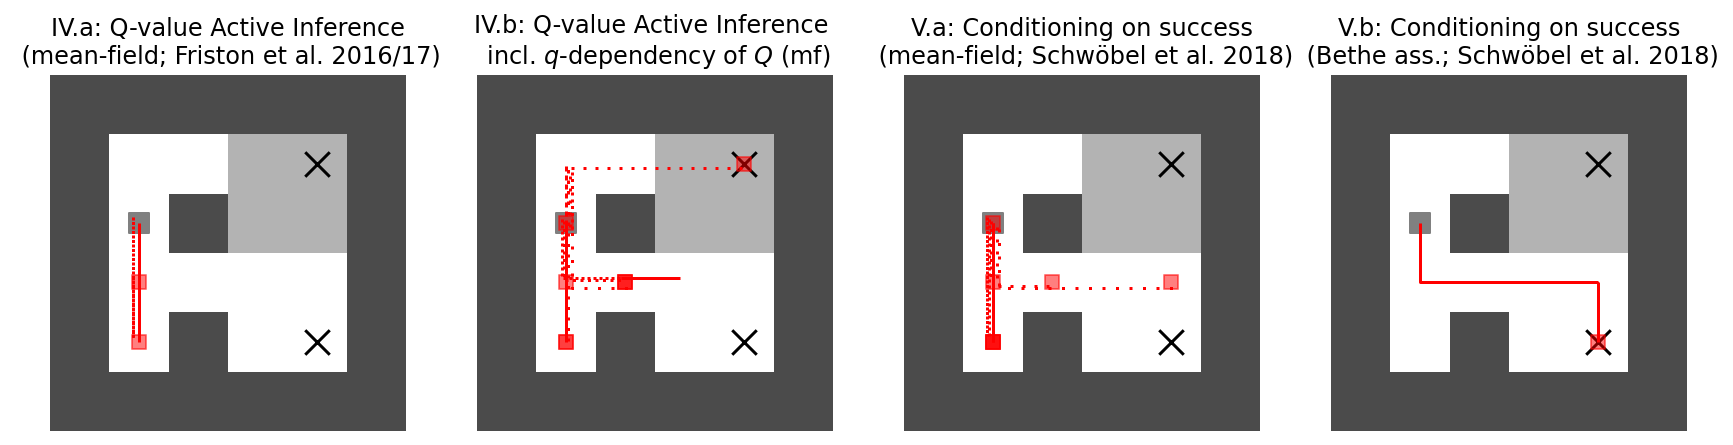

In [5]:
# load trajectories from file and show most probable ones
env = GridEnv(plan=plan1,render=False)
select = ['qmf','qgd','toussmf','toussbethe']
trajectories = load_trajectories(select,walls=True)
show_paths(env,sigmas,steps,trajectories,select,spec=[1,len(select)],num=8)

---
In the following we write $\mathrm{Tr}_{s' s}^a$ as a shorthand for the transition probability $p_0(s'|s,a)$, and "$\text{norm.}$" to indicate normalization (a function of the variables in the conditional of the resulting distribution only).

## I. Conditioning on $p_\mathrm{des}$ (Jeffrey conditionalization)

The following approach first samples a desired state $x_\mathrm{des}$ from the desired distribution $p_\mathrm{des}$ and then uses exact Bayesian inference over actions conditioned on $X_T = x_\mathrm{des}$. 

#### for $t=0,\dots,T-1$:

(1) Observe $X_t=x_t$ and sample a desired observation $x_\mathrm{des} \sim p_\mathrm{des}(X)$


(2) Inference over states:

$\qquad p(S_t|\mathbf{x}_t,\mathbf{a}_{t-1}) \leftarrow \left\{ \begin{array}{cc} \frac{1}{\text{norm.}}\, p_0(x_0|S_0) p_0(S_0) & \text{if } t=0 \\ \frac{1}{\text{norm.}} \, p_0(x_t|S_t) p(S_t|\mathbf{x}_{t-1},\mathbf{a}_{t-1}) & \text{if } t>0  \end{array}\right. $
    
where $p(S_t|\mathbf{x}_{t-1},\mathbf{a}_{t-1}) = \sum_{s_{t-1}} \mathrm{Tr}_{S_t s_{t-1}}^{a_{t-1}} p(s_{t-1}|\mathbf{x}_{t-1},\mathbf{a}_{t-2})$ is determined using the Bayes posterior $p(S_{t-1}|\mathbf{x}_{t-1},\mathbf{a}_{t-2})$ from the previous timestep.


(3) Inference over actions:

$$
p(A_t,\dots,A_{T-1}|X_T = x_\mathrm{des},\mathbf{x}_t,\mathbf{a}_{t-1}) = \frac{1}{\text{norm.}} \, \sum_{s_T}p_0(x_\mathrm{des}|s_{T}) \sum_{s_t,\dots,s_{T-1}} \mathrm{Tr}_{s_T s_{T-1}}^{A_{T-1}} \cdots \mathrm{Tr}_{s_{t+1} s_t}^{A_t} \, p(s_t|\mathbf{x}_t,\mathbf{a}_{t-1})
$$


(4) Sample $a_t$ from $\sum_{a_{t+1},\dots,a_{T-1}} p(A_t,a_{t+1},\dots,a_{T-1}|x_\mathrm{des})$ or sample a full trajectory and ignore everything but $a_t$.


Note that this corresponds to Jeffrey conditioning as it produces actions sampled from $\sum_{x_T} p(\mathbf{A}_f|x_T) p_\mathrm{des}(x_T)$. 

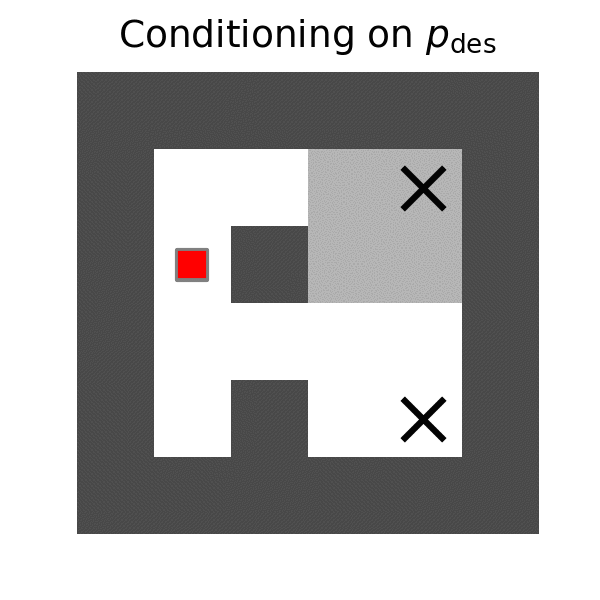

In [5]:
# show sample behavior
with open(Path("gifs/agent_jeff.gif"),'rb') as f:
    Image(data=f.read(), format='png', width='200')

In [ ]:
# set up grid world (jupyter notebook only)
%matplotlib notebook
env = GridEnv(plan=plan1,render=True,speed='slow',verbose=True,figsize=(2,2))
agent = Jeffrey(env,vision=sigmas,maxSteps=steps)
_=env.ax.imshow(agent.sigmas,alpha=.3,cmap=plt.get_cmap('Greys'))

In [8]:
# run the agent (jupyter notebook only)
env.run(agent,episodes=3,steps=steps)

Navigating...Done: Success after 5 steps!
Navigating...Fail: Episode stopped after 5 steps
Navigating...Fail: Episode stopped after 5 steps


---

## II. Conditioning on success (Control as inference, e.g. Toussaint 2006)

The other option to perform inference over actions is to introduce an auxiliary variable $R$ which encodes the occurence of desired outcomes $x_\mathrm{des}$ by assuming a probability $p(R=1|X_\tau=x_\mathrm{des})$, usually defined through a given reward function (cf. Section 5.3 $(iii)$ of the article).

#### for $t=0,\dots,T-1$:

(1) Observe $X_t=x_t$.


(2) Inference over states: $p(S_t|\mathbf{x}_t,\mathbf{a}_{t-1})$ same as in I.


(3) Inference over actions: Introduce a binary success variable $R$ so that $R=1$ encodes the occurence of desired outcomes, for example by using a conditional of the form $p_0(R=1|X_T=x_T) := p_\mathrm{des}(x_T)$, which is multiplied to the full joint $p_0$ to obtain a new joint $p_0(R,\mathbf{X}_{t+1:T},\mathbf{S},\mathbf{A}_{t:T-1}|\mathbf{x}_t,\mathbf{a}_{t-1})$. Success can now be considered an observable on which can be conditioned to obtain a distribution over inferred action trajectories: 

$$
p(A_t,\dots,A_{T-1}|R=1,\mathbf{x}_t,\mathbf{a}_{t-1}) = \frac{1}{\text{norm.}} \, \sum_{x_T} p_0(R=1|x_T) \sum_{s_T} p_0(x_T|s_T)\,\sum_{s_t,\dots,s_{T-1}} \mathrm{Tr}_{s_T s_{T-1}}^{A_{T-1}} \cdots \mathrm{Tr}_{s_{t+1} s_t}^{A_t} \, p(s_t|\mathbf{x}_t,\mathbf{a}_{t-1})
$$
    
(4) Sample $a_t$ from $\sum_{a_{t+1},\dots,a_{T-1}} p(A_t,a_{t+1},\dots,a_{T-1}|R=1,\mathbf{x}_t,\mathbf{a}_{t-1})$ or sample a full trajectory and ignore everything but $a_t$.

Remark: One can also get rid of the $T$-dependency by treating $T$ as a random variable with a distribution of the form $p_0(T) \propto \gamma^T$ for some $0<\gamma<1$. 

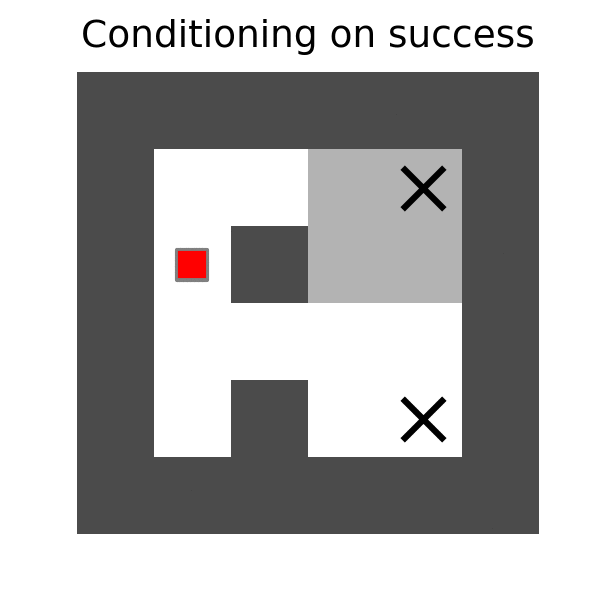

In [6]:
# show sample behavior
with open(Path("gifs/agent_touss.gif"),'rb') as f:
    Image(data=f.read(), format='png', width='200')

In [ ]:
# set up grid world (jupyter notebook only)
%matplotlib notebook
env = GridEnv(plan=plan1,render=True,speed='slow',verbose=True,figsize=(2,2))
agent = Toussaint(env,vision=sigmas,maxSteps=steps)
_=env.ax.imshow(agent.sigmas,alpha=.3,cmap=plt.get_cmap('Greys'))

In [13]:
# run the agent (jupyter notebook only)
env.run(agent,episodes=3,steps=steps)

Navigating...Done: Success after 5 steps!
Navigating...Done: Success after 5 steps!
Navigating...Done: Success after 5 steps!


---

## III. Soft-maximizing expected utility

#### for $t=0,\dots,T-1$:

(1) Observe $X_t=x_t$.


(2) Same as in I.
  
  
(3) Calculate soft-max action policy (with precision parameter $\alpha$):

$$
p(\mathbf{A}_{t:T-1}) \leftarrow \frac{1}{\text{norm.}}\, p_0(\mathbf{A}_{0:T-1}) \, e^{\alpha\sum_{\tau=t+1}^T \langle U(X_\tau)\rangle_{p_0(X_\tau|S_\tau)p(S_\tau|\mathbf{A}_{t:\tau-1})}}
$$

where $U$ is a given utility function over future observations (e.g. $U(x)=\delta_{x,x_\mathrm{des}}$ in the gridworld example below) 
    
$$
p(S_\tau|\mathbf{A}_{t:\tau-1}) = \sum_{s_t,\dots,s_{\tau-1}} \mathrm{Tr}_{S_\tau s_{\tau-1}}^{A_{\tau-1}} \cdots \mathrm{Tr}_{s_{t+1} s_t}^{A_t} p(s_t|\mathbf{x}_t,\mathbf{a}_{t-1})
$$

(4) Sample $a_t$ from $\sum_{a_{t+1},\dots,a_{T-1}} p(A_t,a_{t+1},\dots,a_{T-1})$ or sample a full trajectory and ignore everything but $a_t$.

Note that, here we have implemented a very simple version of a utility-based agent with information constraints, where the precision-parameter $\alpha$ in the soft-maximization (3.) controls the trade-off between maximizing expected utility and staying close to the prior $p_0(A)$ (a constraint on the KL divergence between $q(A)$ and $p_0(A)$). In this simple environment, a choice of $\alpha=1$ (which we have chosen for all the simulations with a soft-max in this notebook) is pretty much equivalent to a rational agent that maximizes expected utility without any constraints ($\alpha\to\infty$). See e.g. Grau-Moya et al. 2016 for grid world simulations that specifically target robust behaviour under model uncertainty and information constraints.  

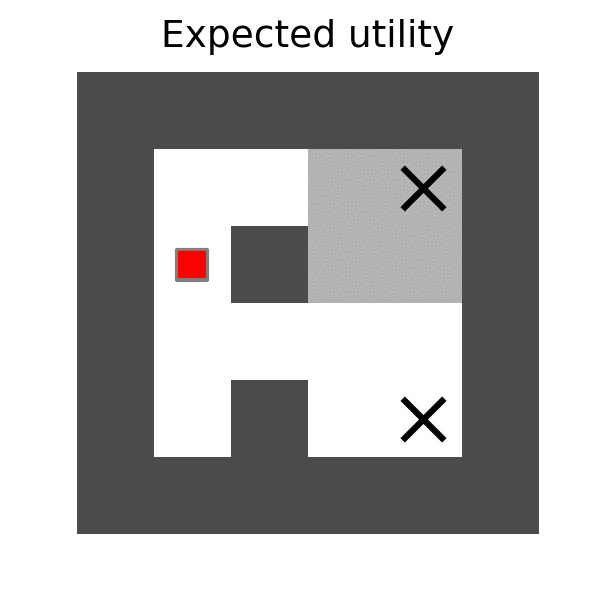

In [7]:
# show sample behavior
with open(Path("gifs/agent_util.gif"),'rb') as f:
    Image(data=f.read(), format='png', width='200')

In [ ]:
# set up grid world (jupyter notebook only)
%matplotlib notebook
env = GridEnv(plan=plan1,render=True,speed='slow',verbose=True,figsize=(2,2))
agent = ExactInference(env, vision=sigmas, maxSteps=steps)
_=env.ax.imshow(agent.sigmas,alpha=.3,cmap=plt.get_cmap('Greys'))

In [16]:
# run the agent (jupyter notebook only)
env.run(agent,episodes=3,steps=steps)

Navigating...Done: Success after 5 steps!
Navigating...Done: Success after 5 steps!
Navigating...Done: Success after 5 steps!


---

## IV. Q-value Active Inference (Friston et al. 2016/2017)
Here, we have implemented the 2016/2017 version of Active Inference based on the partial mean-field assumption, which is  the most capable one among the $Q$-value versions of Active Inference (2013-2017). However, as we can see in the simulation below, even the partial mean-field assumption is too restrictive to plan actions in a simple grid world. Moreover, following the literature, the $q$-dependency of $Q$ was ignored in the derivation of the update equations. In IV.b, we show that the resulting behavior differs when correctly considering the $q$-dependency $Q=Q(q)$ in the update steps (using gradient descent). In IV.c, we show the predefined "prior" behavior that a simple soft-max policy using the _exact_ value function $Q=Q(p_\mathrm{pred})$ would achieve (note that, in the case of our idealized grid world environment, the exact solution requires less computational effort than the mean-field versions).

### IV.a _Mean-field approximation,_ $Q=Q(q)$, _$q$-dependency <span style="color:red">ignored</span> in gradients_

#### for $t=0,...,T-1$:
(1) observe $X_t = x_t$

(2) initialize $q(S_0),\dots,q(S_t),q(S_{t+1}|A_t),\dots,q(S_T|A_t,\dots,A_{T-1})$, and $q(A_t,\dots,A_{T-1})$.

(3) repeat until convergence: 

$$
q(S_0) \leftarrow \frac{1}{\text{norm.}} \, p_0(S_0) \, p_0(x_0|S_0) \left\{ \begin{array}{cc} e^{\langle \log \mathrm{Tr}_{S_1,S_0}^{A_0}\rangle_{q(S_1|A_0)q(A_0)}} & \text{if } t=0 \\ e^{\langle \log \mathrm{Tr}_{S_1 S_0}^{a_0}\rangle_{q(S_1)}} & \text{if } t>0  \end{array}\right.
$$

for $\tau=1,\dots,T-1$: 

$$
\qquad q(S_\tau|\mathbf{A}_{t:\tau-1}) \leftarrow  \left\{ \begin{array}{cc}\frac{1}{\text{norm.}}\, p_0(x_\tau|S_\tau) \, e^{\langle \log \mathrm{Tr}_{S_\tau S_{\tau-1}}^{a_{\tau-1}}\rangle_{q(S_{\tau-1})}} e^{ \langle \log \mathrm{Tr}_{S_{\tau+1}S_{\tau}}^{a_{\tau}}\rangle_{q(S_{\tau+1})}} & \text{if } \tau<t  \\
     \frac{1}{\text{norm.}} \, p_0(x_t|S_t) e^{\langle \log \mathrm{Tr}_{S_t S_{t-1}}^{a_{t-1}} \rangle_{q(S_{t-1})}} e^{\langle \log \mathrm{Tr}_{S_{t+1} S_t}^{A_t}\rangle_{q(S_{t+1}|A_t) q(A_t)}} & \text{if } \tau = t \\
     \frac{1}{\text{norm.}} \,e^{\langle \log \mathrm{Tr}_{S_\tau S_{\tau-1}}^{A_{\tau-1}}\rangle_{q(S_{\tau-1}|A_t,\dots,A_{\tau-2})}} e^{ \langle \log \mathrm{Tr}_{S_{\tau+1}S_{\tau}}^{A_{\tau}}\rangle_{q(S_{\tau+1}|A_t,\dots,A_{\tau})q(A_{\tau})} } & \text{if } \tau>t\end{array}\right.
$$

end for

$$
q(S_T|\mathbf{A}_{t:T-1}) \leftarrow \frac{1}{\text{norm.}} \, e^{\langle \log \mathrm{Tr}_{S_T S_{T-1}}^{A_{T-1}}\rangle_{q(S_{T-1}|A_t,\dots,A_{T-2})}}
$$

$$
q(A_t,\dots,A_{T-1}) \leftarrow \frac{1}{\text{norm.}}\, p_0(\mathbf{A}_{t:T-1}) \, e^{\alpha \sum_{\tau={t+1}}^T G_\tau(\mathbf{A}_{t:\tau-1})}
$$
   
where $G_\tau(\mathbf{A}_{t:\tau-1}) = -\mathcal F_{\mathbf{S}}(\mathbf{A}_{t:\tau-1}) + Q_\tau(\mathbf{A}_{t:\tau-1})$ is determined by

$$
\langle \log \mathrm{Tr}_{S_\tau,S_{\tau-1}}^{A_{\tau-1}} \rangle_{q(S_\tau|\mathbf{A}_{t:\tau-1}) q(S_{\tau-1}|\mathbf{A}_{t:\tau-2})} - \langle \log q(S_\tau|\mathbf{A}_{t:\tau-1})\rangle_{q(S_\tau|\mathbf{A}_{t:\tau-1})} + \langle \log p_0(X_\tau|S_\tau)\rangle_{p_0(X_\tau|S_\tau)q(S_\tau|\mathbf{A}_{t:\tau-1})}\\
+ \langle \log p_\mathrm{des}(X_\tau)\rangle_{p_0(X_\tau|S_\tau)q(S_\tau|\mathbf{A}_{t:\tau-1})} - \left\langle \log \sum_{s_\tau} p_0(X_\tau|s_\tau) q(s_\tau|\mathbf{A}_{t:\tau-1})\right\rangle_{p_0(X_\tau|S_\tau) q(S_\tau|\mathbf{A}_{t:\tau-1})}
$$

(4) Sample $a_t$ from $\sum_{a_{t+1},\dots,a_{T-1}} q(A_t,a_{t+1},\dots,a_{T-1})$.

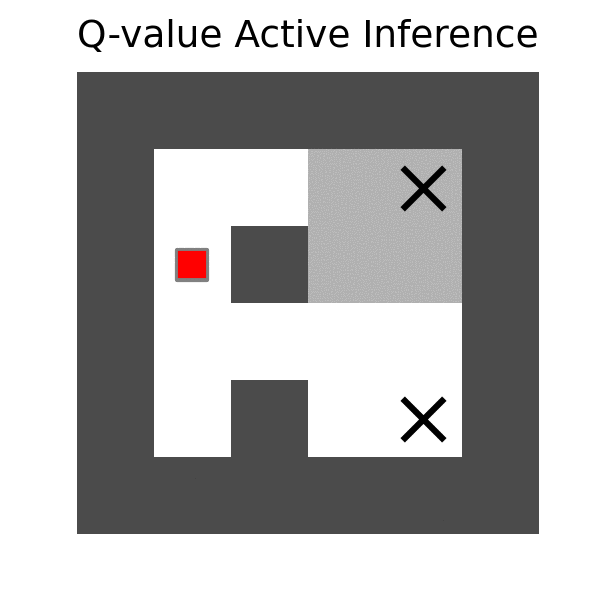

In [8]:
# show sample behavior
with open(Path("gifs/agent_qmf.gif"),'rb') as f:
    Image(data=f.read(), format='png', width='200')

In [ ]:
# set up grid world (jupyter notebook only)
%matplotlib notebook
env = GridEnv(plan=plan1,render=True,speed='slow',verbose=True,figsize=(2,2))
agent = ActiveInference2016(env,vision=sigmas,maxSteps=steps)
_=env.ax.imshow(agent.sigmas,alpha=.3,cmap=plt.get_cmap('Greys'))

In [12]:
# run the agent (jupyter notebook only)
env.run(agent,episodes=3,steps=steps)

Navigating...Fail: Episode stopped after 5 steps
Navigating...Fail: Episode stopped after 5 steps
Navigating...Fail: Episode stopped after 5 steps


### IV.b _Mean-field approximation,_ $Q=Q(q)$, $q$-dependency <span style="color:red">respected</span> in gradients

Here, the update step for $q(S_\tau|\mathbf{A}_{t:\tau-1})$ for $\tau>t$ is done using gradient descent, since there is no closed-form solution when the $q$-dependency of $Q$ is taken into account.

#### for $t=0,...,T-1$:
(1) observe $X_t = x_t$

(2) initialize $q(S_0),\dots,q(S_t),q(S_{t+1}|A_t),\dots,q(S_T|A_t,\dots,A_{T-1})$, and $q(A_t,\dots,A_{T-1})$.

(3) repeat until convergence: 

$$
q(S_0) \leftarrow \textit{same as IV.a}
$$

for $\tau=1,\dots,T$: 

$$
\qquad q(S_\tau|\mathbf{A}_{t:\tau-1}) \leftarrow  \left\{ \begin{array}{cc} \textit{same as IV.a} & \text{if } \tau<t  \\
    \textit{same as IV.a} & \text{if } \tau = t \\
     \mathrm{argmin}_{q(S_\tau|\mathbf{A}_{t:\tau-1})} \underbrace{\left\langle \log \frac{q(S_\tau|\mathbf{A}_f) \sum_{s_\tau} p_0(X_\tau|s_\tau) q(s_\tau|\mathbf{A}_f)}{\mathrm{Tr}_{S_\tau S_{\tau-1}}^{A_{\tau-1}} \mathrm{Tr}_{S_{\tau+1}S_\tau}^{A_\tau} \, p_0(X_\tau|S_\tau) \, p_\mathrm{des}(X_\tau)}  \right\rangle_q}_{=\langle \mathcal F_{\mathbf{S}}(\mathbf{x}_t,\mathbf{a}_{t-1},\mathbf{A}_f) - Q(q(S_\tau|\mathbf{A}_f))\rangle_{q(\mathbf{A}_f)}\,+\,\text{const.}}  & \text{if } \tau>t\end{array}\right.
$$

end for

$$
q(A_t,\dots,A_{T-1}) \leftarrow \textit{same as IV.a}
$$


(4) Sample $a_t$ from $\sum_{a_{t+1},\dots,a_{T-1}} q(A_t,a_{t+1},\dots,a_{T-1})$.


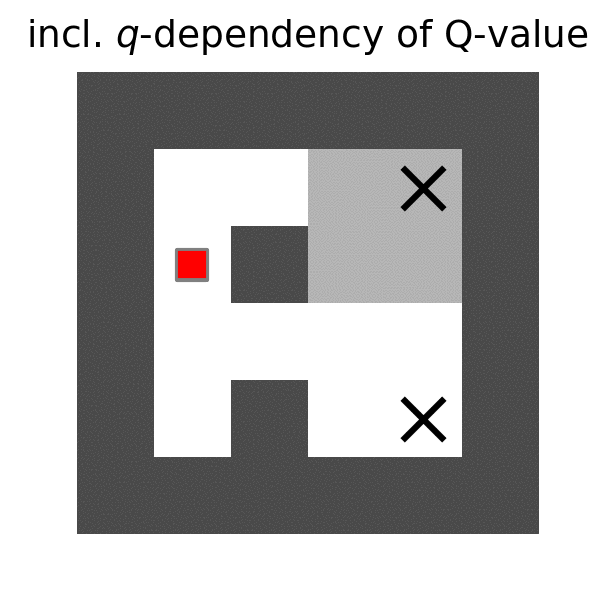

In [9]:
# show sample behavior
with open(Path("gifs/agent_qgd.gif"),'rb') as f:
    Image(data=f.read(), format='png', width='200')

In [ ]:
# set up grid world (jupyter notebook only)
env = GridEnv(plan=plan1,render=True,speed='slow',verbose=True,figsize=(2,2))
agent = ActiveInference2016_GD(env,vision=sigmas,maxSteps=steps,iterations=10,alpha=1.0)
_=env.ax.imshow(agent.sigmas,alpha=.3,cmap=plt.get_cmap('Greys'))

In [22]:
# run the agent (jupyter notebook only)
env.run(agent,episodes=3,steps=steps)

Navigating...Fail: Episode stopped after 5 steps
Navigating...Fail: Episode stopped after 5 steps
Navigating...Fail: Episode stopped after 5 steps


### Remark: _Gridworld without inner walls_

The mean-field approach IV.a can succeed sometimes in simple situations such as when the inner walls in the above gridworld environment are removed:

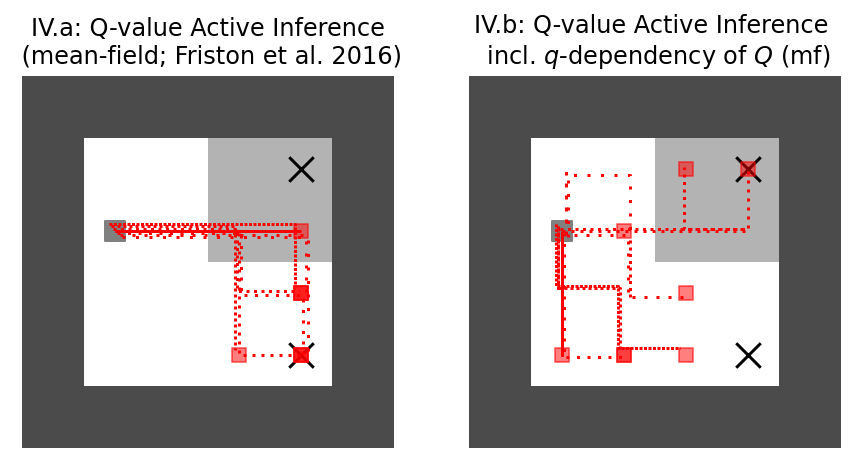

In [6]:
# load trajectories from file and show most probable ones
env = GridEnv(plan=plan2,render=False)
select = ['qmf','qgd']
trajectories = load_trajectories(select,walls=False)
show_paths(env,sigmas,steps,trajectories,select,spec=[1,2],num=8)

Note that, __if the $q$-dependency of $Q$ is respected__ in the update equations (IV.b) then the __resulting behavior is very different__ to when it is ignored (IV.a).

 ### IV.c _Soft-max of_ $Q = Q_{exact} := Q(p_\mathrm{pred})$

The value-function $Q$ in Active Inference has a built-in entropy term that penalizes states with bad vision (state-observation probability with high entropy) and thus the _presupposed_ action distribution $\frac{1}{Z}p_0(\mathbf{A})e^{Q(\mathbf{A})}$ produces a similar behavior as the utility-based approach, when we use the exact predictive distribution

$$
p_\mathrm{pred}(S_\tau|\mathbf{A}_{t:\tau-1}) = \sum_{s_t,\dots,s_{\tau-1}} \mathrm{Tr}_{S_\tau s_{\tau-1}}^{A_{\tau-1}} \cdots \mathrm{Tr}_{s_{t+1} s_t}^{A_t} \underbrace{p(s_t|\mathbf{x}_t,\mathbf{a}_{t-1})}_{\text{ exact Bayesian inference, as in I}}
$$

instead of $q(S_\tau|\mathbf{A}_{t:\tau-1})$ to define the value function 

$$ 
Q_\mathrm{exact}:=Q(p_\mathrm{pred}) = \sum_{\tau=t+1}^T \left\langle \log \frac{p_0(X_\tau|S_\tau) p_\mathrm{des}(X_\tau)}{\sum_{s_\tau}p_0(X_\tau|s_\tau) \, \color{red}{p_\mathrm{pred}(s_\tau|\mathbf{A}_{t:\tau-1})}}\right\rangle_{p_0(X_\tau|S_\tau) \color{red}{p_\mathrm{pred}(S_\tau|\mathbf{A}_{t:\tau-1})}}
$$

#### for $t=0,\dots,T-1$:

(1) observe $X_t=x_t$
   
   
(2) Inference over states: Same as in I.
 
 
(3) calculate $Q$ and action policy:

$$
p(\mathbf{A}_{t:T-1}) \leftarrow \frac{1}{\text{norm.}} \, p_0(\mathbf{A}_{0:T-1}) e^{\alpha \sum_{\tau=t+1}^T Q_\tau(\mathbf{A}_{t:\tau-1})}
$$

where $Q_\tau(\mathbf{A}_{t:\tau-1})$ is determined by

$$
\langle \log p_0(X_\tau|S_\tau)\rangle_{p_0(X_\tau|S_\tau)p(S_\tau|\mathbf{A}_{t:\tau-1})}+ \langle \log p_\mathrm{des}(X_\tau)\rangle_{p_0(X_\tau|S_\tau)p(S_\tau|\mathbf{A}_{t:\tau-1})} - \left\langle \log \sum_{s_\tau} p_0(X_\tau|s_\tau) p(s_\tau|\mathbf{A}_{t:\tau-1})\right\rangle_{p_0(X_\tau|S_\tau) p(S_\tau|\mathbf{A}_{t:\tau-1})}
$$

$$
\qquad p(S_\tau|\mathbf{A}_{t:\tau-1}) = \sum_{s_t,\dots,s_{\tau-1}} \mathrm{Tr}_{S_\tau s_{\tau-1}}^{A_{\tau-1}} \cdots \mathrm{Tr}_{s_{t+1} s_t}^{A_t} p(s_t|\mathbf{x}_t,\mathbf{a}_{t-1})
$$


(4) Sample $a_t$ from $\sum_{a_{t+1},\dots,a_{T-1}} p(A_t,a_{t+1},\dots,a_{T-1})$.

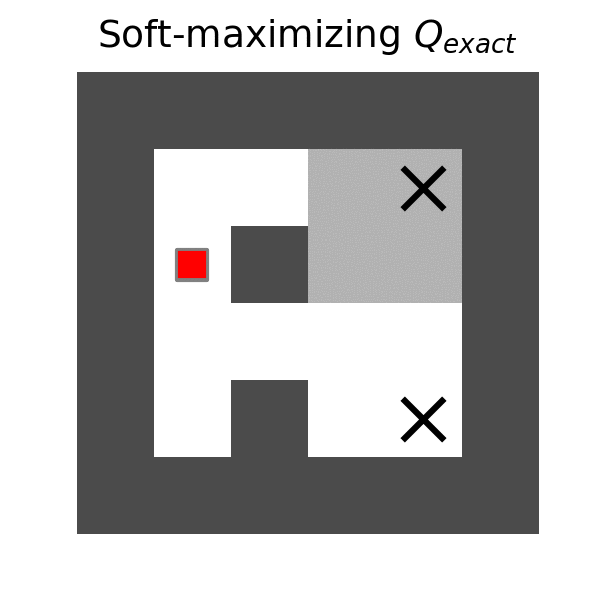

In [10]:
# show sample behavior
with open(Path("gifs/agent_qexact.gif"),'rb') as f:
    Image(data=f.read(), format='png', width='200')

In [ ]:
# set up grid world (jupyter notebook only)
env = GridEnv(plan=plan1,render=True,speed='slow',verbose=True,figsize=(2,2))
agent = ExactQ201516(env,vision=sigmas,maxSteps=steps)
_=env.ax.imshow(agent.sigmas,alpha=.3,cmap=plt.get_cmap('Greys'))

In [47]:
# run the agent (jupyter notebook only)
env.run(agent,episodes=3,steps=steps)

Navigating...Done: Success after 5 steps!
Navigating...Done: Success after 5 steps!
Navigating...Done: Success after 5 steps!


---

## V. Direct Active Inference (Schöbel et al. 2018): *A special case of Control as Inference*

### V.a _Mean-field assumption_

#### for $t=0,...,T-1$:

(1) observe $X_t = x_t$


(2) initialize $q(S_0),\dots,q(S_t),q(S_{t+1}|A_t),\dots,q(S_T|A_t,\dots,A_{T-1})$, and $q(A_t,\dots,A_{T-1})$.


(3) repeat until convergence: 

$$
q(S_0) \leftarrow \textit{same as IV.a}
$$

for $\tau=1,\dots,T-1$: 
    
$$
q(S_\tau|\mathbf{A}_{t:\tau-1}) \leftarrow  \left\{ \begin{array}{cc} \text{same as in 2016/2017} & \text{if } \tau\leq t  \\
     \frac{1}{\text{norm.}} \,e^{\langle \log \mathrm{Tr}_{S_\tau S_{\tau-1}}^{A_{\tau-1}}\rangle_{q(S_{\tau-1}|A_t,\dots,A_{\tau-2})} \, + \langle \log \mathrm{Tr}_{S_{\tau+1}S_{\tau}}^{A_{\tau}}\rangle_{q(S_{\tau+1}|A_t,\dots,A_{\tau})q(A_{\tau})} \, + \langle \log p_\mathrm{des}(X_\tau)\rangle_{p_0(X_\tau|S_\tau)}}    & \text{if } \tau>t\end{array}\right.
$$
    
end for

$$
q(S_T|\mathbf{A}_{t:T-1}) \leftarrow \frac{1}{\text{norm.}} \, e^{\langle \log \mathrm{Tr}_{S_T S_{T-1}}^{A_{T-1}}\rangle_{q(S_{T-1}|A_t,\dots,A_{T-2})} \, + \langle \log p_\mathrm{des}(X_T)\rangle_{p_0(X_T|S_T)}}
$$

$$
q(A_t,\dots,A_{T-1}) \leftarrow \frac{1}{\text{norm.}}\, p_0(\mathbf{A}_{t:T-1}) \, e^{\alpha \sum_{\tau={t+1}}^T G_\tau(\mathbf{A}_{t:T-1})}
$$
   
where $G_\tau(\mathbf{A}_{t:T-1}) = -\mathcal F_{\mathbf{S}}(\mathbf{A}_{t:T-1}) - D(\mathbf{A}_{t:T-1})$ is determined by

$$
\langle \log \mathrm{Tr}_{S_\tau,S_{\tau-1}}^{A_{\tau-1}} \rangle_{q(S_\tau|\mathbf{A}_{t:\tau-1}) q(S_{\tau-1}|\mathbf{A}_{t:\tau-2})} - \langle \log q(S_\tau|\mathbf{A}_{t:\tau-1})\rangle_{q(S_\tau|\mathbf{A}_{t:\tau-1})} + \langle \log p_\mathrm{des}(X_\tau)\rangle_{p_0(X_\tau|S_\tau) q(S_\tau|\mathbf{A}_{t:\tau-1})}
$$


(4) Sample $a_t$ from $\sum_{a_{t+1},\dots,a_{T-1}} q(A_t,a_{t+1},\dots,a_{T-1})$.


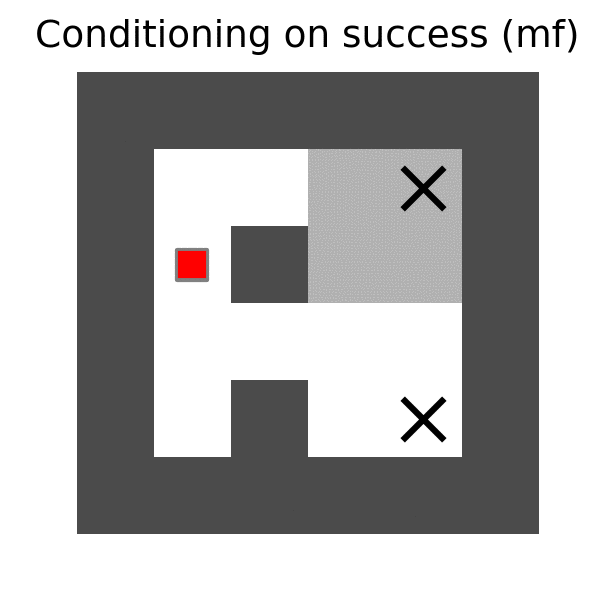

In [12]:
# show sample behavior
with open(Path("gifs/agent_toussmf.gif"),'rb') as f:
    Image(data=f.read(), format='png', width='200')

In [ ]:
# set up grid world (jupyter notebook only)
%matplotlib notebook
env = GridEnv(plan=plan1,render=True,speed='slow',verbose=True,figsize=(2,2))
agent = Toussaint_mf(env,vision=sigmas,maxSteps=steps)
_=env.ax.imshow(agent.sigmas,alpha=.3,cmap=plt.get_cmap('Greys'))

In [7]:
# run the agent (jupyter notebook only)
env.run(agent,episodes=3,steps=steps)

Navigating...Fail: Episode stopped after 5 steps
Navigating...Fail: Episode stopped after 5 steps
Navigating...Fail: Episode stopped after 5 steps


### V.b _Bethe assumption_

Since the Bethe assumption leads to a belief propagation algorithm that results in exact factor marginals, the resulting behavior is identical with Control as Inference (Section II above). In S1 Appendix we provide more details and a derivation of the update equations for the one-step example from the article.     

---

# 2. _Explanation_

The action policies in the above algorithms are essentially given by (for simplicity neglecting fixed action priors and considering only one step)

$$
p(A) = \left\{\begin{array}{cc} \sum_{x}\underbrace{\frac{p_\mathrm{pred}(x|A)}{\mathcal Z(x)}}_{=p_\mathrm{Bayes}(A|x)} \,  p_\mathrm{des}(x) & (\textit{Conditioning on $p_\mathrm{des}$}) \\ \frac{1}{\mathcal Z}\, \sum_{x} p_\mathrm{pred}(x|A) \, p_\mathrm{des}(x)  & (\textit{Conditioning on success}) \\ \frac{1}{\mathcal Z} \, \exp\Big[ \sum_x p_\mathrm{pred}(x|A)  \, \log p_\mathrm{des}(x)\Big] & (\textit{Expected Utility}) \\ 
\frac{1}{\mathcal Z} \exp\Big[\underbrace{\sum_x q(x|A) \, \log p_\mathrm{des}(x) + \textit{other terms}}_{= \,-F_S(A)+Q(q)} \Big] & (\textit{$Q$-value Active Inference}) \\
\frac{1}{\mathcal Z} \exp\Big[ \underbrace{-D_\mathrm{KL}(p_\mathrm{pred}(X|A)\|p_\mathrm{des}(X)) - \langle H(p_0(X|S))\rangle_{p_0(X,S|A)}}_{= \, Q(p_\mathrm{pred})\, =\, \langle \log p_\mathrm{des} \rangle + \langle D_\mathrm{KL}(p_0(X|S)\|p_\mathrm{pred}(X|A))\rangle }\Big] & (\textit{softmax of  $Q_\mathrm{exact}=Q(p_\mathrm{pred})$})\end{array}\right.
$$

where $p_\mathrm{pred}(X|A)$ denotes the predictive distribution of future consequences $X$ given the action $A$ resulting from the generative model $p_0$, $\mathcal Z$ denotes normalization constants, and $\mathcal Z(x)=\sum_a p_\mathrm{pred}(x|a)$ normalizes the Bayes posterior $p(A|x)$ in Jeffrey's conditioning rule.


We can now understand the behaviour of the algorithms as follows:

* __Conditioning on $p_\mathrm{des}$ vs. conditioning on success__: When comparing the two ways of directly performing inference over actions, i.e. Jeffrey conditioning and Control as Inference (e.g. Toussaint 2006), we can see that they only differ in the order of normalizing and taking the expected value over $X$. This means that, in the approach using naive Jeffrey conditionalization, first a goal $X=x$ is sampled from $p_\mathrm{des}$ and then a path is planned by calculating $p(A|x)$, which is why the simulation can fail in case the top goal is sampled from $p_\mathrm{des}$, which is in an area of bad vision. In contrast, Toussaint's version of inference weighs the desirability of an outcome $p_\mathrm{des}(x)$ with its realizability given by $p_\mathrm{pred}(x|A)$, so that which $x$ is chosen to plan a path depends on how well it can be navigated to.

* __Expected Utility__: Similar to Control as Inference, in expected utility approaches the utility of outcomes, e.g. $U(x)=\log p_\mathrm{des}(x)$, is weighted with their realizability $p_\mathrm{pred}(x|A)$ to decide which $A$'s should be preferred. The difference to Control as Inference is how the desired distribution is transformed into a utility, which here is a completely arbitrary choice (for comparison's sake, we assume a desired distribution $p_\mathrm{des}$ for all approaches, which is uniformly distributed over the goal states).

* __Q-value Active Inference__: In $Q$-value Active Inference based on mean-field approximations, the action distribution contains contributions from the state updates (perception steps), due to the shared variational free energy as an optimization objective. However, there are two issues here: 
    - The mean-field assumption seems to be __too restrictive__ for reliable navigation in a grid world (we encourage the reader to play around with other grid world setups in the jupyter notebook on github). 
    - Neglecting the $q$-dependency of $Q$, as is done in the vast majority of Active Inference literature, __produces different behavior__  than when this dependency is included using a gradient descent algorithm. This is a fundamental issue with $Q$-value active inference that is nowhere acknowledged in the literature (it is instead considered of little importance for numerical simulations in Friston et al. 2016), even though in our grid world simulation the inclusion of this dependency produces unexplainable behavior (see IV.b above). Instead, one usually motivates the exclusion of this $q$-dependency by a separation of the full free energy adopted from variational Bayesian inference with fixed references, where it follows from the fact that the full free energy can be written as a sum of a free energy over states and a KL divergence that is independent of state distributions because there the reference does not have the extra $q$-dependency (see S4 Appendix for details). However, for Active Inference this essentially means that one gives up the optimization of a single free energy but optimizes two different free energy expressions for action and perception.


* __Softmax of $Q_\mathrm{exact}$__: When using the true predictive distribution $p_\mathrm{pred}(S|A)$ instead of the trial distribution $q(S|A)$ in $Q$, then the resulting behavior from a soft-max action distribution is similar to Control as Inference and the expected utility approach. This is partly because $Q$ has a built-in term that explicitly punishes high outcome variability (high entropy of $p_0(X|S)$), resulting in a bias towards the bottom target, but also because $Q_\mathrm{exact}$ differs from the expected utility $\langle \log p_\mathrm{des}\rangle$ only by the average KL divergence between $p_0(X|S)$ and $p_\mathrm{pred}(X|A)$, which is small for a perfect transition matrix. Note that the extra dependency of $Q$ on $p_0(X|S)$ can, however, introduce a strong behavioral variability, in the sense that it can result in qualitatively different behavior in situations where $p_\mathrm{pred}(X|A)$ is constant (see the simple example in Fig 8 of the article).